# Comparação dos times

## Carrega pacotes

In [1]:
library(httr)
library(rjson)
library(jsonlite)
library(dplyr)
library(tidyr)
library(magrittr)
library(stringr)
library(lubridate)
library(tibble)
library(ggplot2)
library(ggradar)
library(scales)


Attaching package: ‘jsonlite’

The following objects are masked from ‘package:rjson’:

    fromJSON, toJSON


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Carrega dados

In [19]:
load("dados_cartola_2017_por_rodada.RData")
load("informacoes_partidas_rodada_7.RData")
load("pontuacao_cartola.RData")

## Carrega funções

In [20]:
ajuste_lag <- function(x){
  
  ifelse( is.na( x - lag(x) ) == TRUE, x, x - lag(x) )
  
}

## Ajusta dados jogadores

In [21]:
dados_cartola_2017_por_rodada %<>%
  arrange( atleta_id, rodada_id ) %>%
  select( atleta_id, FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  group_by( atleta_id ) %>%
  mutate_all( funs( ajuste_lag(.) ) ) %>% 
  bind_cols( dados_cartola_2017_por_rodada %>%
               arrange( atleta_id, rodada_id ) %>% 
               select( -atleta_id, -FC, -PE, -RB, -SG, -CA, -FD, -FS, -FF, -I, -G, -DD, -GS, 
                       -A, -CV, -FT, -GC, -DP, -PP ), .) %>%
  mutate( apelido = replace( apelido, apelido == "Patrick", "Patrick Correia" ) ) %>% 
  mutate( apelido = replace( apelido, apelido == "Vinicius Júnior", "Vinicius Junior" ) ) %>%
  mutate( apelido = replace( apelido, apelido == "Matheus Sávio", "Matheus Savio" ) ) %>%
  data.frame()

## Ajusta dados clubes

In [22]:
label_clubes <- dados_cartola_2017_por_rodada %>% distinct( clube_id, clube)

informacoes_partidas %<>%
  right_join(., x = label_clubes, by = c("clube_id" = "partidas.clube_visitante_id") ) %>%
  rename(., partidas.clube_visitante_id = clube_id ) %>% 
  rename(., partidas.clube_visitante_nome = clube ) %>%
  right_join(., x = label_clubes, by = c("clube_id" = "partidas.clube_casa_id") ) %>%
  rename(., partidas.clube_casa_id = clube_id ) %>% 
  rename(., partidas.clube_casa_nome = clube ) %>%
  select( partidas.clube_casa_nome,
          partidas.clube_visitante_nome )

informacoes_partidas

partidas.clube_casa_nome,partidas.clube_visitante_nome
Fluminense,Grêmio
Flamengo,Ponte Preta
Santos,Palmeiras
Corinthians,Cruzeiro
Atlético-MG,Atlético-PR
Coritiba,Bahia


## Força times casa

In [6]:
forca_times_casa <- dados_cartola_2017_por_rodada %>%
  filter(mandante == 'S') %>%
  group_by(clube, posicao) %>%
  summarise(pontuacao = mean(pontos_num) ) %>%
  data.frame %>% 
  group_by( posicao ) %>%
  mutate(pontuacao_norm = rescale(pontuacao) ) %>% 
  data.frame()

## Força times fora

In [7]:
forca_times_fora <- dados_cartola_2017_por_rodada %>%
  filter(mandante == 'N') %>%
  group_by(clube, posicao) %>%
  summarise(pontuacao = mean(pontos_num) ) %>%
  data.frame %>% 
  group_by( posicao ) %>%
  mutate(pontuacao_norm = rescale(pontuacao) ) %>% 
  data.frame()

rm(dados_cartola_2017_por_rodada)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,537633,28.8,940480,50.3,940480,50.3
Vcells,675807,5.2,1650153,12.6,1649337,12.6


## Confrontos

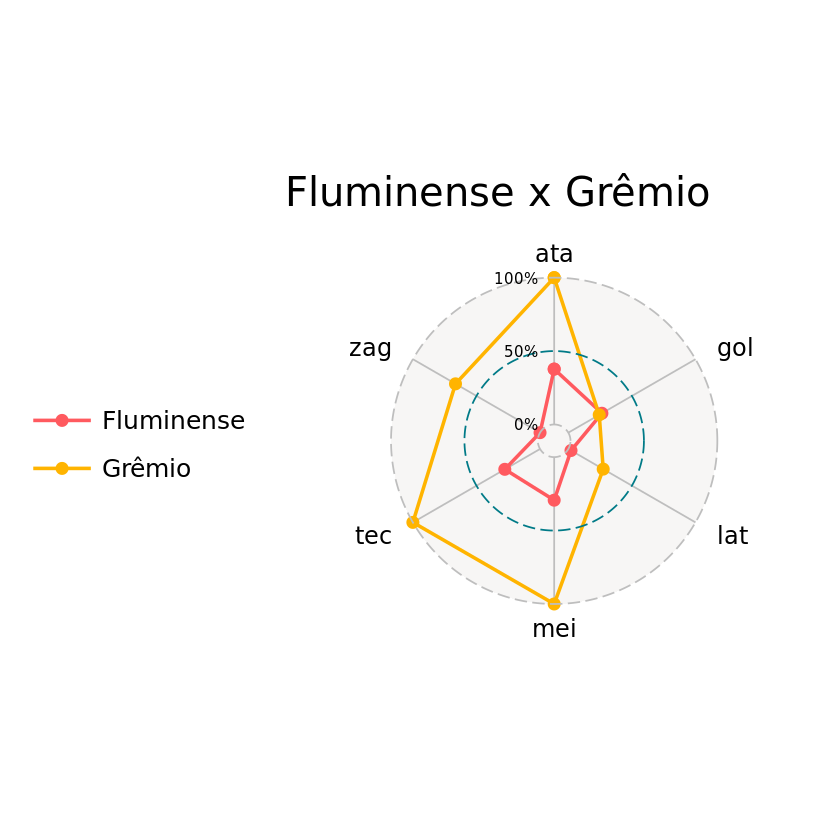

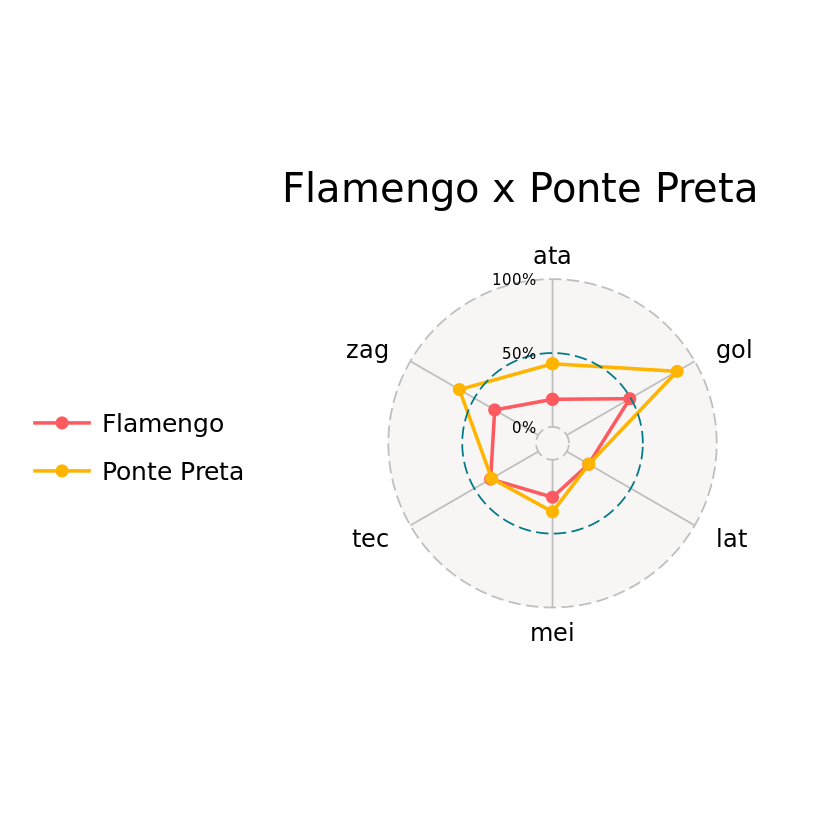

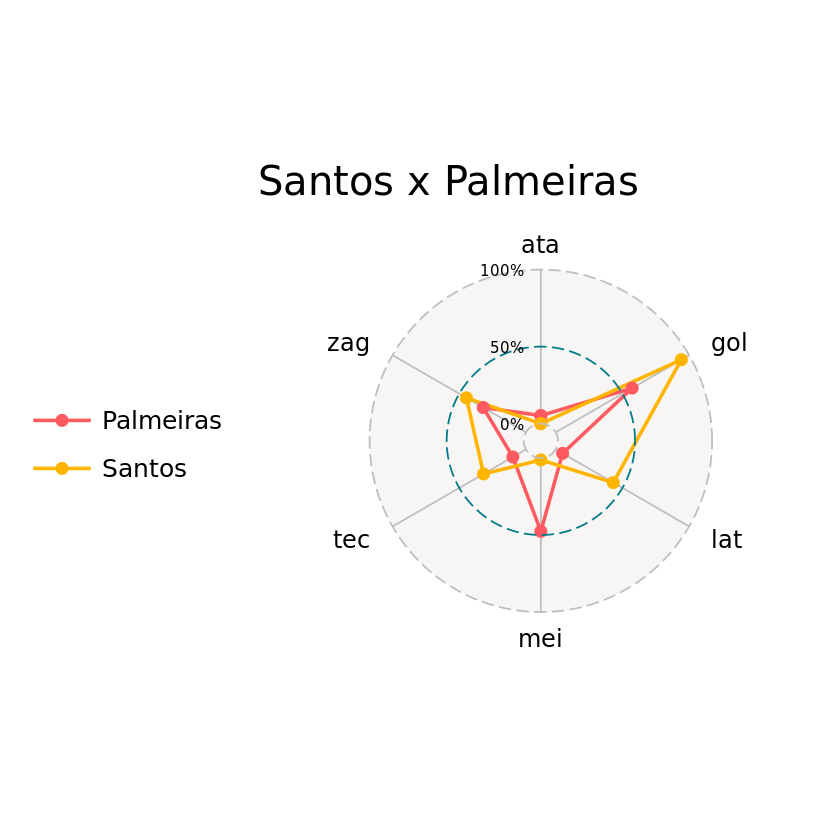

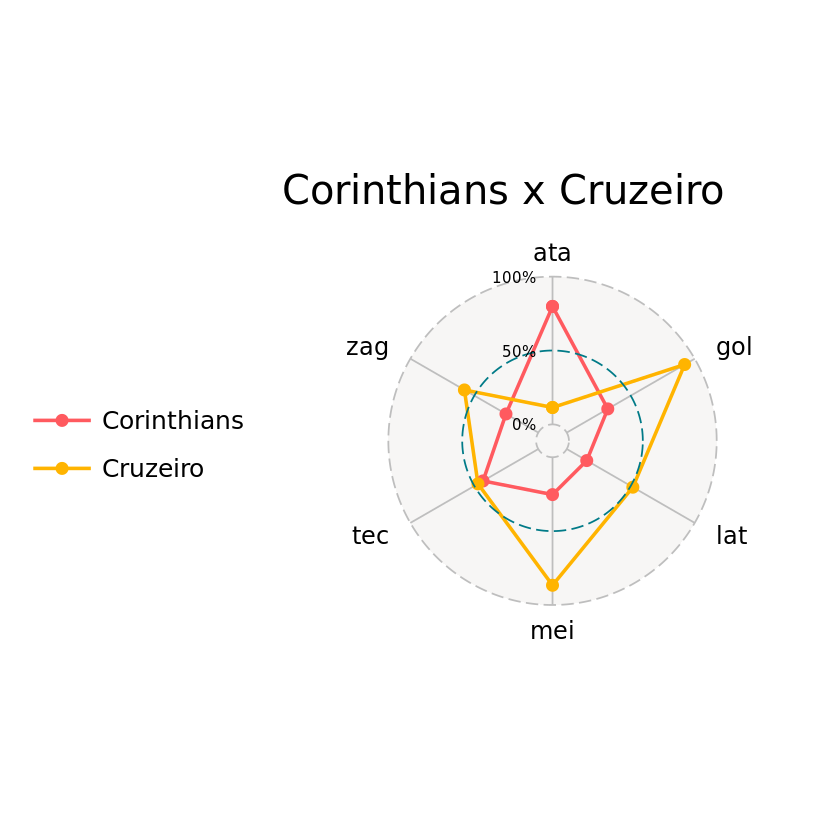

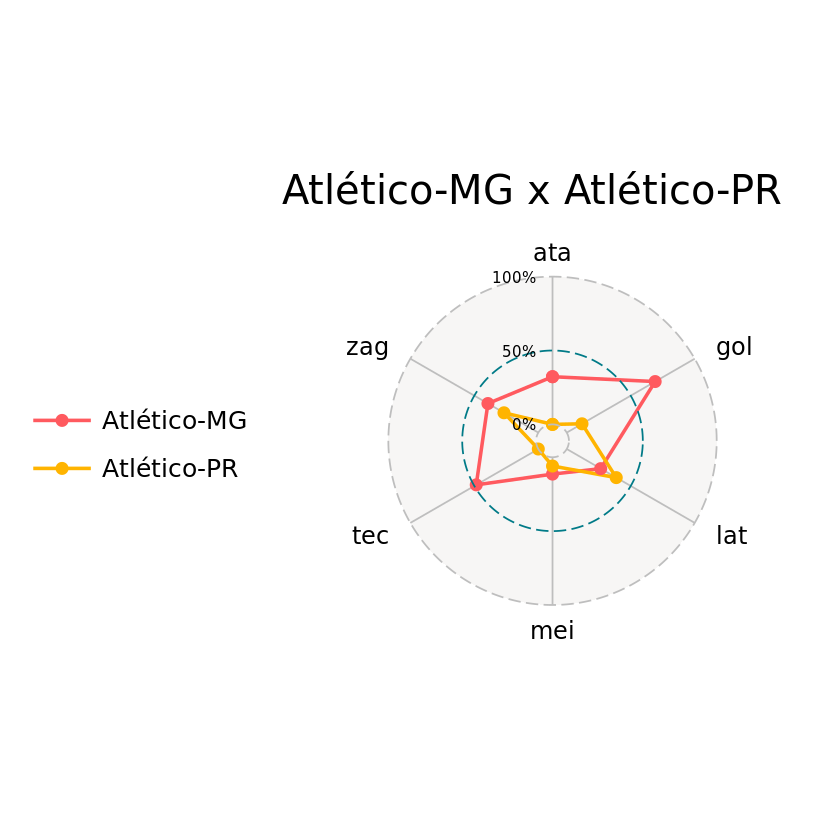

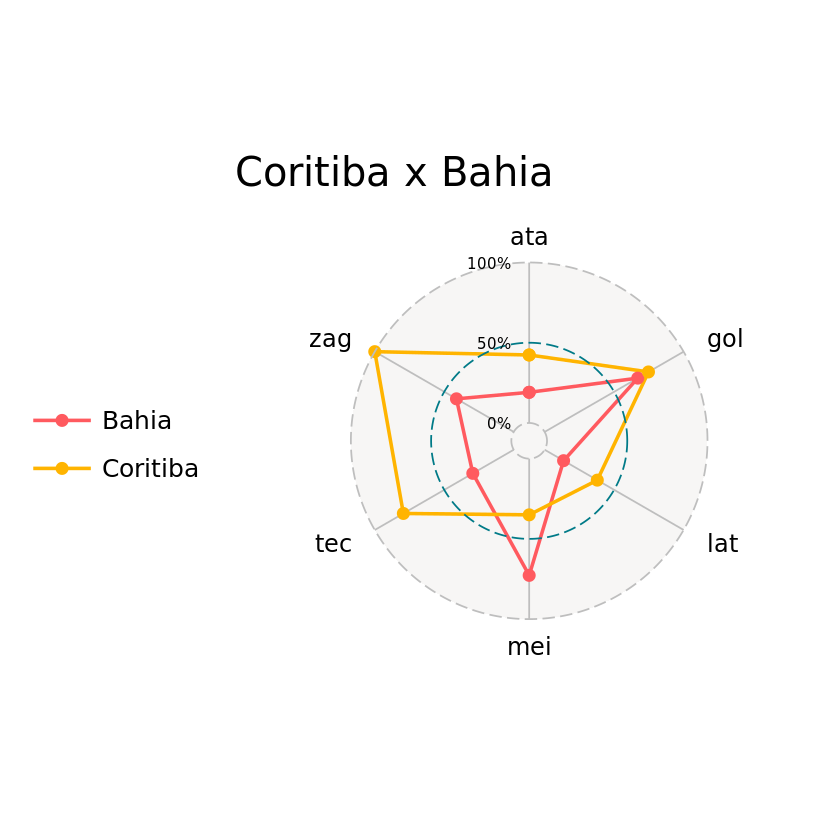

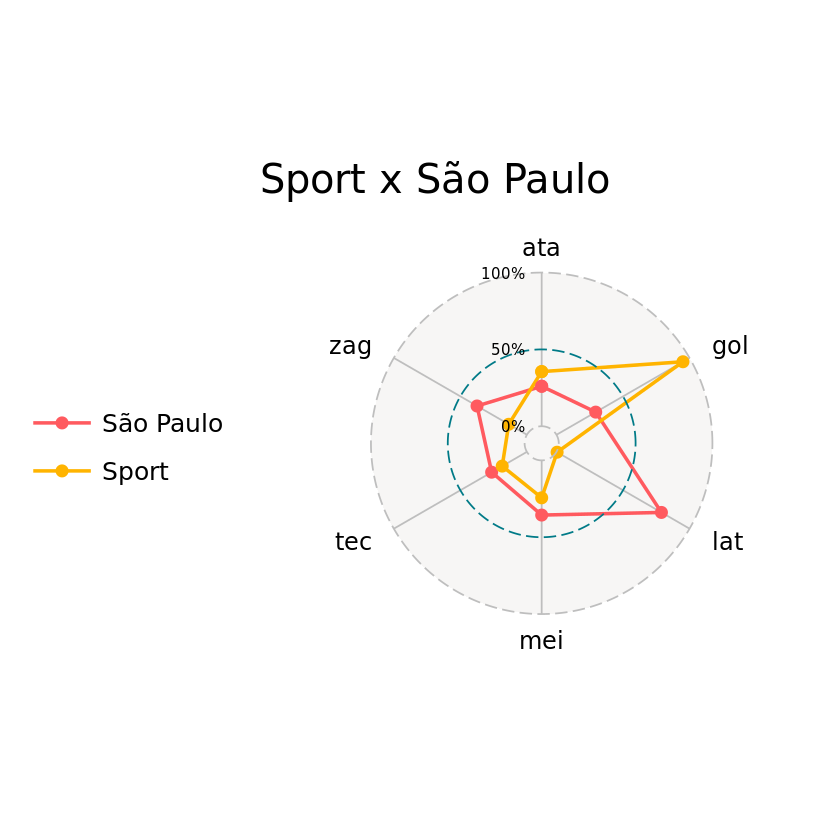

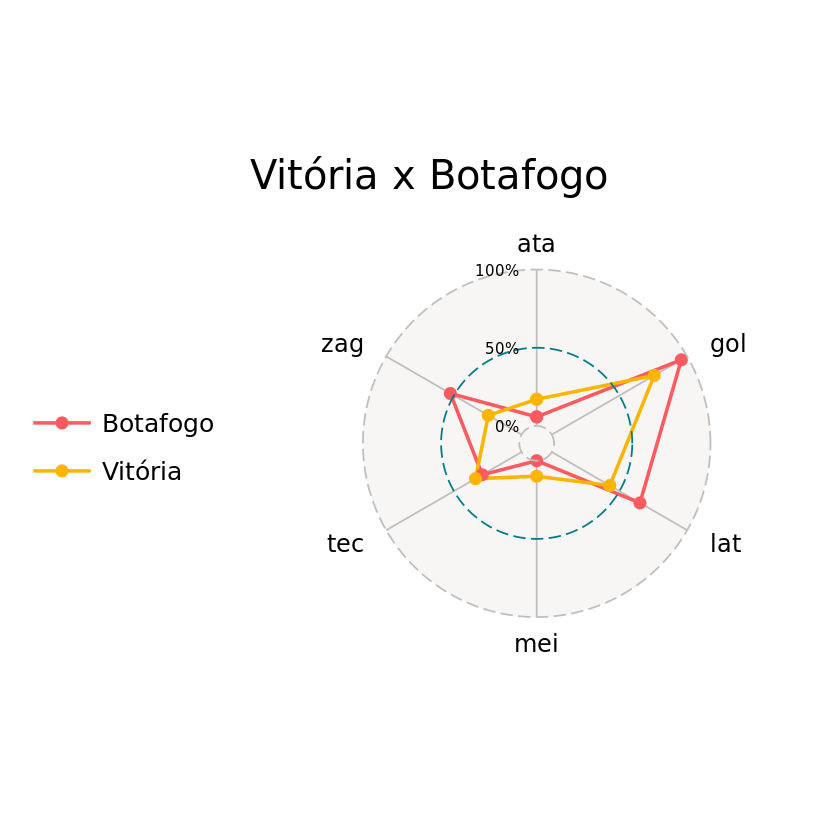

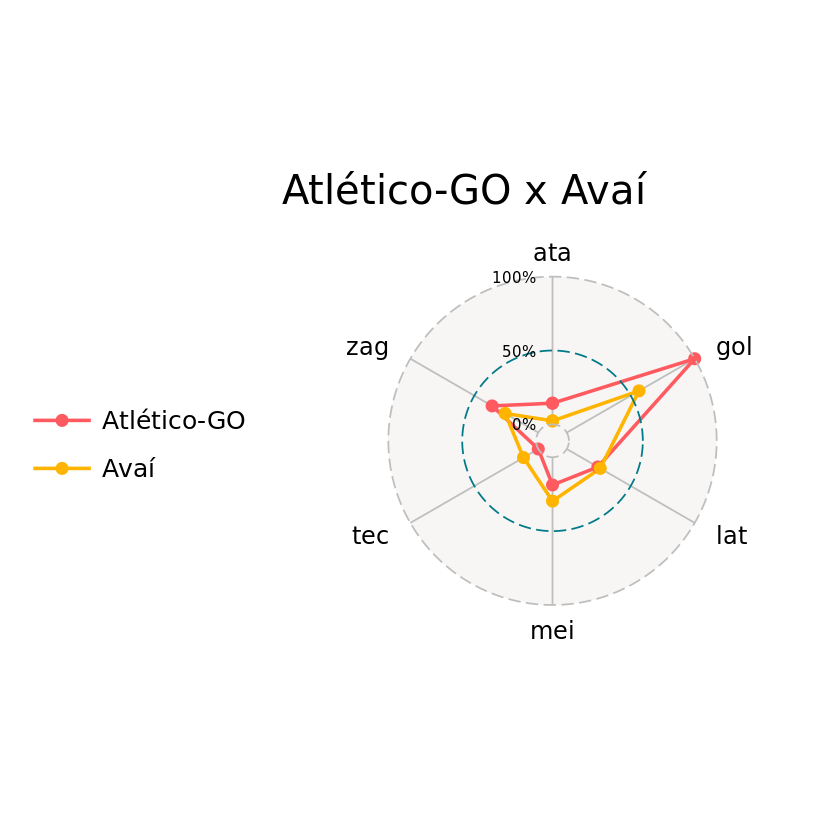

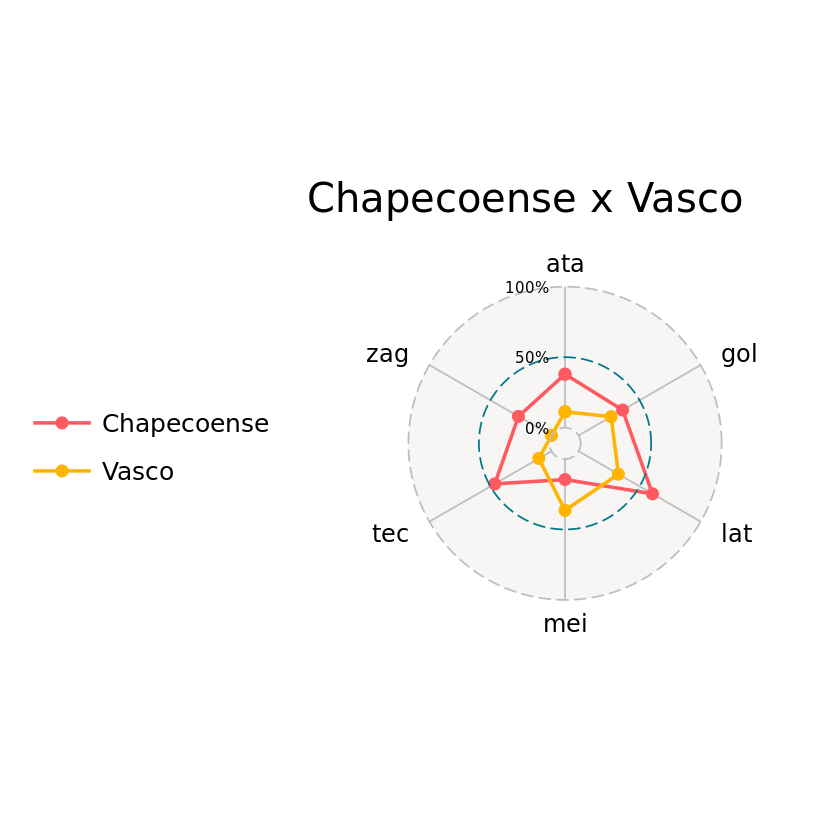

In [32]:
for( i in 1:dim(informacoes_partidas)[1] ){
    
    time_casa <- informacoes_partidas$partidas.clube_casa_nome[i]
    time_fora <- informacoes_partidas$partidas.clube_visitante_nome[i]
    
    time1 <- forca_times_casa %>% filter(clube == time_casa)
    time2 <- forca_times_fora %>% filter(clube == time_fora)
    
    comparacao <- rbind(time1, time2)
    
    show( comparacao %>% 
     select( -pontuacao ) %>% 
     spread( key = posicao, value = pontuacao_norm ) %>% 
     ggradar( group.line.width = 1,
              group.point.size = 3,
              grid.label.size = 4,
              axis.label.size = 5,
              legend.text.size = 15,
              label.gridline.min = TRUE,
              plot.title = paste0(time_casa, " x ", time_fora) ) )
    
}